In [112]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Exploratory Data Analysis

In [113]:
df = pd.read_csv("datasets/winequality-red.csv", delimiter=";")

In [114]:
# no strange outliers
df.describe()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
count,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000,1599.000000
mean,8.319637,0.527821,0.270976,2.538806,0.087467,15.874922,46.467792,0.996747,3.311113,0.658149,10.422983,5.636023
std,1.741096,0.179060,0.194801,1.409928,0.047065,10.460157,32.895324,0.001887,0.154386,0.169507,1.065668,0.807569
min,4.600000,0.120000,0.000000,0.900000,0.012000,1.000000,6.000000,0.990070,2.740000,0.330000,8.400000,3.000000
25%,7.100000,0.390000,0.090000,1.900000,0.070000,7.000000,22.000000,0.995600,3.210000,0.550000,9.500000,5.000000
50%,7.900000,0.520000,0.260000,2.200000,0.079000,14.000000,38.000000,0.996750,3.310000,0.620000,10.200000,6.000000
75%,9.200000,0.640000,0.420000,2.600000,0.090000,21.000000,62.000000,0.997835,3.400000,0.730000,11.100000,6.000000
max,15.900000,1.580000,1.000000,15.500000,0.611000,72.000000,289.000000,1.003690,4.010000,2.000000,14.900000,8.000000


In [115]:
# example value of a data
df.iloc[0]

fixed acidity            7.4000
volatile acidity         0.7000
citric acid              0.0000
residual sugar           1.9000
chlorides                0.0760
free sulfur dioxide     11.0000
total sulfur dioxide    34.0000
density                  0.9978
pH                       3.5100
sulphates                0.5600
alcohol                  9.4000
quality                  5.0000
Name: 0, dtype: float64

In [116]:
# no NAN
df.isna().sum()

fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64

# Data Processessing

In [117]:
# spliting 
df = df.sample(frac = 1)

train_proportion = 0.8
n = len(df)
print('Size of dataset: ', str(n))

# Put the first ntrain observations in the DataFrame df into the training set, and the rest into the test set
t = int(train_proportion * n)

target = df["quality"]
data = df.loc[:, ~df.columns.isin(["quality"])]

# the following variable records the features of examples in the training set
train_x = data.iloc[:t]
# the following variable records the features of examples in the test set
test_x = data.iloc[t:]
# the following variable records the labels of examples in the training set
train_y = target[:t]
# the following variable records the labels of examples in the test set
test_y = target[t:]

Size of dataset:  1599


# Common Functions

In [165]:
def square_loss(y_true, y_pred):
    n = y_true.shape[0]
    return np.sum((y_pred - y_true) ** 2) / n

def rank_feature_importance(feature_name, feature_score):
    n = feature_name.shape[0]
    lst = [(feature_name[i], feature_score[i]) for i in range(n)]
    lst.sort(key=lambda x:x[1], reverse=True)
    # uncomment to see just the rank without the score
    # return [x[0] for x in lst]
    return lst

def select_features_filter(all_features, target_features):
    lst = []
    for i in range(len(all_features)):
        if all_features[i] in target_features:
            lst.append(True)
        else:
            lst.append(False)
    return lst

# Random Forest

In [126]:
from sklearn.ensemble import RandomForestClassifier

In [189]:
# Observation: when n_estimators=100 the ranked_importance changes!
for i in range(1):
    rf_clf = RandomForestClassifier(random_state=i, n_estimators=1000)
    rf_clf.fit(train_x, train_y)
    y_pred = rf_clf.predict(test_x)
    loss = square_loss(test_y, y_pred)
    print(f"random state = {i}")
    print(f"loss = {loss}")
    ranked_importance = rank_feature_importance(train_x.columns, rf_clf.feature_importances_)
    print(ranked_importance)

random state = 0
loss = 0.375
[('alcohol', 0.1461694451825062), ('sulphates', 0.10779825120717466), ('total sulfur dioxide', 0.10697711059274166), ('volatile acidity', 0.10607038305196409), ('density', 0.09545155957032084), ('chlorides', 0.07964010892950603), ('fixed acidity', 0.07516494076185287), ('pH', 0.0736947968016041), ('citric acid', 0.07356224378694849), ('residual sugar', 0.06918516943246926), ('free sulfur dioxide', 0.06628599068291188)]


In [172]:
all_features = list(train_x.columns)
ranked_features = [ x[0] for x in ranked_importance]

random_states = [0, 1, 2, 3, 4]
num_estimators = 2000

square_loss_matrix = np.zeros((len(random_states), len(ranked_features)))
for i in range(len(random_states)):
    print(f"random state = {i}")
    rs = random_states[i]
    square_loss_lst = []
    for j in range(1, len(ranked_features) + 1):
        target_features = ranked_features[:j]
        features_filter = select_features_filter(all_features, target_features)
        train_x_selected_features = train_x.loc[:, features_filter]
        test_x_selected_features = test_x.loc[:, features_filter]
        rf_clf = RandomForestClassifier(random_state=rs, n_estimators=num_estimators)
        rf_clf.fit(train_x_selected_features, train_y)
        square_loss_value = square_loss(test_y, rf_clf.predict(test_x_selected_features))
        square_loss_lst.append(square_loss_value)
    square_loss_matrix[i,:] = np.array(square_loss_lst)

random state = 0
random state = 1
random state = 2
random state = 3
random state = 4


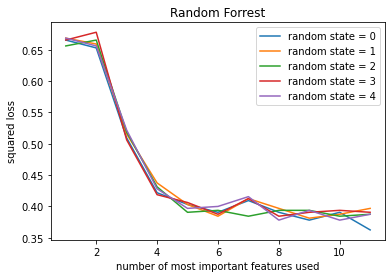

In [173]:
x_axis = np.arange(1, len(ranked_features) + 1)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix[i], label=f"random state = {i}")
plt.xlabel("number of most important features used")
plt.ylabel("squared loss")
plt.title("Random Forrest")
plt.legend()
plt.show()

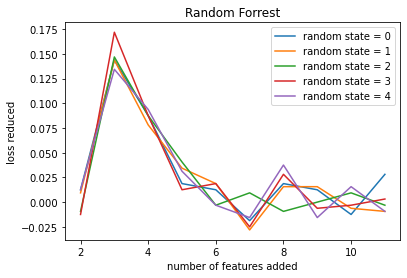

In [174]:
# squared loss difference
square_loss_matrix_0 = square_loss_matrix[:,:-1]
square_loss_matrix_1 = square_loss_matrix[:,1:]
square_loss_matrix_diff = square_loss_matrix_0 - square_loss_matrix_1

x_axis = np.arange(2, square_loss_matrix_diff.shape[1] + 2)
for i in range(len(random_states)):
    plt.plot(x_axis,square_loss_matrix_diff[i], label=f"random state = {i}")
plt.xlabel("number of features added")
plt.ylabel("loss reduced")
plt.title("Random Forrest")
plt.legend()
plt.show()


# Lasso Feature Selection

In [254]:
from sklearn import linear_model
from sklearn.feature_selection import SelectFromModel
from sklearn.preprocessing import normalize

In [302]:
def select_feature(all_features, feature_filter):
    lst = []
    for i in range(len(feature_filter)):
        
        if feature_filter[i]:
            lst.append(all_features[i])
    return lst

n = 10
loss_lst = []
features_used = []
alphas = np.linspace(0.00001,0.008,30)
for a in alphas:
    # print(f"a = {a} =========")
    lasso_clf = linear_model.Lasso(alpha=a, normalize=True, random_state=1)
    lasso_clf.fit(train_x, train_y)
    feature_filter = ~np.isclose(lasso_clf.coef_, 0)
    selected_features = select_feature(train_x.columns, feature_filter)
    print(selected_features)
    y_pred = lasso_clf.predict(test_x)
    loss = square_loss(test_y, y_pred)
    loss_lst.append(loss)
    features_used.append(np.sum(feature_filter))
    # print(f"loss = {loss}")

['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['fixed acidity', 'volatile acidity', 'chlorides', 'total sulfur dioxide', 'pH', 'sulphates', 'alcohol']
['volatile acidity', 'chlorides', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'total sulfur dioxide', 'sulphates', 'alcohol']
['volatile acidity', 'sulphates', 'alcohol']
['volatile acidity', 'sulphates', 'alcohol']
['volatile acidity', 'sulphates', 'alcohol']
['volatile aci

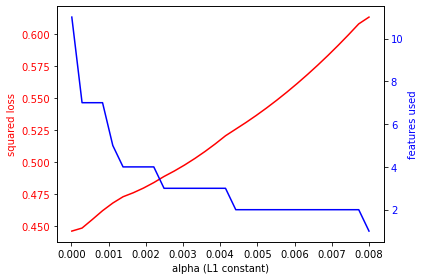

In [309]:
fig, ax1 = plt.subplots()

color = 'red'
ax1.set_xlabel('alpha (L1 constant)')
ax1.set_ylabel('squared loss', color=color)
ax1.plot(alphas, loss_lst, color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

color = 'blue'
ax2.set_ylabel('features used', color=color)  # we already handled the x-label with ax1
ax2.plot(alphas, features_used, color=color)
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.title("Lasso squared Loss vs features used")
plt.show()